# Text classification

This notebook shows how to do text classification starting from raw text (as a set of text files on disk). 

In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load the data: IMDB movie review sentiment classification

In [ ]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

In [ ]:
!ls

The `aclImdb` folder contains a train and test subfolder:

In [ ]:
!ls aclImdb/

In [ ]:
!ls aclImdb/test

In [ ]:
!ls aclImdb/train

We are only interested on  `pos` and `neg` subfolders, so let's delete the rest:

In [ ]:
!rm -r aclImdb/train/unsup

The `aclImdb/train/pos` and `aclImdb/test/neg` folders contain text files, each of which represents on review (either positive or negative).

In [ ]:
!cat aclImdb/train/neg/5003_4.txt

In [ ]:
!cat aclImdb/train/pos/4002_8.txt

In [2]:
# Distribution of positive and negative reviews on train and test set

train_path = "aclImdb/train"
test_path = "aclImdb/test"

print("====================Train Set====================")
print(f"We have: {len(os.listdir(train_path+'/pos'))} positive reviews.")
print(f"We have: {len(os.listdir(train_path+'/neg'))} negative reviews.")

print("====================Test Set====================")
print(f"We have: {len(os.listdir(test_path+'/pos'))} positive reviews.")
print(f"We have: {len(os.listdir(test_path+'/neg'))} negative reviews.")

====================Train Set====================
We have: 12500 positive reviews.
We have: 12500 negative reviews.
====================Test Set====================
We have: 12500 positive reviews.
We have: 12500 negative reviews.


You can use the utility `tf.keras.preprocessing.text_dataset_from_directory` to generate a labeled `tf.data.Dataset` object from a set of text files on disk filed into class-specific folders.

Let's use it to generate the training, validation, and test datasets. The validation and training datasets are generated from two subsets of the `train` directory, with 20% samples going to the validation dataset and 80% going to the training dataset.

Having a validation dataset in addition to the test dataset is useful for tuning hyperparameters, such as the model architecture, for which the test dataset should not be used.

Before putting the model out into the real world however, it should be retrained using all available training data (without creating a validation dataset), so its performance is maximized.

When using the `validation_split & subset` arguments, make sure to either specify a random seed, or set `shuffle=False`, so that the validation & training splits you get have overlap.

In [3]:
batch_size = 32
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=42
)

raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "aclImdb/test",
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=42
)

raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "aclImdb/test",
    batch_size=batch_size
)

print(f"Number of batches in raw_train_ds: {tf.data.experimental.cardinality(raw_train_ds)}")
print(f"Number of batches in raw_val_ds: {tf.data.experimental.cardinality(raw_val_ds)}")
print(f"Number of batches in raw_test_ds: {tf.data.experimental.cardinality(raw_test_ds)}")

Found 75000 files belonging to 3 classes.
Using 60000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.
Number of batches in raw_train_ds: 1875
Number of batches in raw_val_ds: 157
Number of batches in raw_test_ds: 782


It's important to take a look at your raw data to ensure your normalization and tokenization will work as expected. We can do that by taking a few examples from the training set and looking at them.

In [ ]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(5):
        print(text_batch.numpy()[i])
        print(label_batch.numpy()[i])

# Prepare the data

Having looked at our data above, we see that the raw text contains HTML break tags of the form `<br />`. These tags will not be removed by the default standardizer (which doesn't strip HTML). Because of this, we will need to create a custom standardization function.

In [5]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import string
import re


# Removing <br/>
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(
        stripped_html, "[%s] % re.escape(string.punctuation)", ""
    )

# Model constants.
max_features = 20000
embedding_dim = 128
sequence_length = 500

Now that we have our custom standardization, we can instantiate our text vectorization layer. We are using this layer to normalize, split, and map strings to integers, so we set our `'output_mode'` to `int`. Note that we are using the default split function, and the custom standardization defined above. We also set an explicit maximum sequence length, since the CNNs later in our model won't support ragged sequences.

In [6]:
text_ds = raw_train_ds.map(lambda x, y: x)

In [7]:
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length,
)

# Let's make a text-only dataset (no labels)
text_ds = raw_train_ds.map(lambda x, y: x)
# Let's call `adapt`
vectorize_layer.adapt(text_ds)

After the vocab layer has been created, we called `adapt` on a text-only dataset to create the vocabulary. You don't have to batch, but for very large datasets this means you are not keeping spare copies of the dataset in memory.

# Two options to vectorize the data

There are 2 ways we can use our text vectorization layer:

- **Option 1: Make it part of the model,** so as to obtain a model that processes raw strings.
- **Option 2: Apply it to the text dataset** to obtain a dataset of word indices, then feed it into a model that expects integer sequences as inputs.

An importance difference between the two is that option 2 enables you to do `asynchronous CPU processing and buffering` of your data when training on GPU. So if you are training the model on GPU, you probably want to go with this option to get best performance. This is what we will do below.

If we were to export our model to production, we'd ship a model that accepts raw strings as input. This can be done after training.

In [8]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label


# Vectorize the data
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

# Do async prefetching / buffering of the data for best performace on GPU
train_ds = train_ds.cache().prefetch(buffer_size=10)
val_ds = val_ds.cache().prefetch(buffer_size=10)
test_ds = test_ds.cache().prefetch(buffer_size=10)

# Build a model

We choose a simple 1D convnet starting with an `Embedding` layer.

In [9]:
from tensorflow.keras import layers

# An integer input for vocab indices.
inputs = tf.keras.Input(shape=(None, ), dtype="int64")

# Add a layer to map those vocab indices into a space of dimensionality
# 'embedding_dim'.
x = layers.Embedding(max_features, embedding_dim)(inputs)
x = layers.Dropout(0.5)(x)

# Conv1D + global max pooling
x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.GlobalMaxPooling1D()(x)

# Add a vanilla hidden layer
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)

# We project onto a single unit output layer, and squash it with a sigmoid:
predictions = layers.Dense(1, activation="sigmoid", name="predictions")(x)

model = tf.keras.Model(inputs, predictions)

# Compile the model with binary crossentropy loss and an adam optimizer.
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model

In [10]:
epochs = 3

# Fit the model using the train and test datasets.
r = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/3
1875/1875 [==============================] - 19s 7ms/step - loss: -271386460160.0000 - accuracy: 0.1663 - val_loss: 1446482542592.0000 - val_accuracy: 0.5076
Epoch 2/3
1875/1875 [==============================] - 8s 4ms/step - loss: -10470732857344.0000 - accuracy: 0.1663 - val_loss: 26188888145920.0000 - val_accuracy: 0.5076
Epoch 3/3
1875/1875 [==============================] - 8s 4ms/step - loss: -70202368720896.0000 - accuracy: 0.1663 - val_loss: 126872880939008.0000 - val_accuracy: 0.5076


# Evaluate the model on the test set

In [11]:
model.evaluate(test_ds)

782/782 [==============================] - 13s 16ms/step - loss: 128519766016000.0000 - accuracy: 0.5000


[128519766016000.0, 0.5]

Text(0.5, 1.0, 'Loss function evolution')

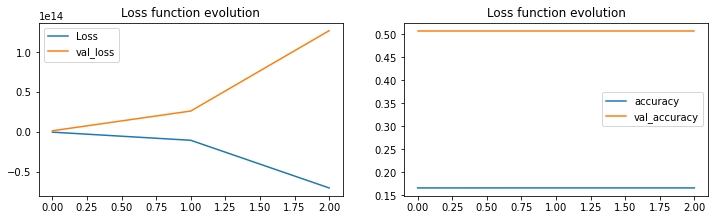

In [12]:
plt.figure(figsize=(12, 7))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Loss function evolution')

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.title('Loss function evolution')

In [ ]:
# from sklearn.metrics import confusion_matrix, classification_report

# pred = model.predict(test_ds)

# print(confusion_matrix(raw_test_ds, pred > 0.5))

# Make an end-to-end model

If you want to obtain a model capable of processing raw strings, you can simply create a new model (using the weights we just trained)

In [ ]:
# A string input
inputs = tf.keras.Input(shape=(1, ), dtype="string")

# Turn strings into vocab indices
indices = vectorize_layer(inputs)

# Turn vocab indices into predictions
outputs = model(indices)

# Our end to end model
end_to_end_model = tf.keras.Model(inputs, outputs)
end_to_end_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]
)

# Test it with `raw_test_ds`, which yields raw strings
end_to_end_model.evaluate(raw_test_ds)